# Data Preprocessing

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import plotly.graph_objects as go
import plotly.express as px

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

from imblearn.over_sampling import SMOTE

df = pd.read_csv("../healthcare-dataset-stroke-data.csv")


### Column Descriptions :

- id: unique identifier
- gender: "Male", "Female" or "Other"
- age: age of the patient
- hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
- heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
- ever_married: "No" or "Yes"
- work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
- Residence_type: "Rural" or "Urban"
- avg_glucose_level: average glucose level in blood
- bmi: body mass index
- smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
- stroke: 1 if the patient had a stroke or 0 if not

Note: "Unknown" in smoking_status means that the information is unavailable for this patient


In [71]:
# import pandas_profiling as pp
# pp.ProfileReport(df)

In [72]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [73]:
df.shape

(5110, 12)

In [74]:
df = df.drop("id", axis=1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [75]:
df.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

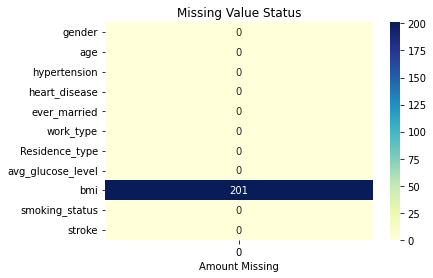

In [76]:
plt.title('Missing Value Status')
ax = sns.heatmap(df.isna().sum().to_frame(),annot=True,fmt='d',cmap='YlGnBu')
ax.set_xlabel('Amount Missing')
plt.show()

In [77]:
# fill missing bmi value with linear regression of age and gender
X_bmi = df[['age','gender',"avg_glucose_level", 'bmi']].copy()

le_gender = LabelEncoder()
X_bmi["gender"] =  le_gender.fit_transform(X_bmi["gender"])

Missing = X_bmi[X_bmi["bmi"].isna()]
X_bmi = X_bmi[~X_bmi.bmi.isna()]
Y_bmi = X_bmi.pop('bmi')

linear_reg = LinearRegression()
linear_reg.fit(X_bmi,Y_bmi)

predicted_bmi = pd.Series(linear_reg.predict(Missing[['age','gender',"avg_glucose_level"]]),index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi
df["bmi"] = df['bmi'].round(decimals = 1)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,32.8,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Exploratory Data Analysis

## Analysis of the whole data set

In [78]:
columns = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']
for i in range(len(columns)):
    print("Unique value of column {column}:".format(column=columns[i]))
    print(df[columns[i]].value_counts(),"\n")

Unique value of column gender:
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64 

Unique value of column hypertension:
0    4612
1     498
Name: hypertension, dtype: int64 

Unique value of column heart_disease:
0    4834
1     276
Name: heart_disease, dtype: int64 

Unique value of column ever_married:
Yes    3353
No     1757
Name: ever_married, dtype: int64 

Unique value of column work_type:
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64 

Unique value of column Residence_type:
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64 

Unique value of column smoking_status:
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64 

Unique value of column stroke:
0    4861
1     249
Name: stroke, dtype: int64 



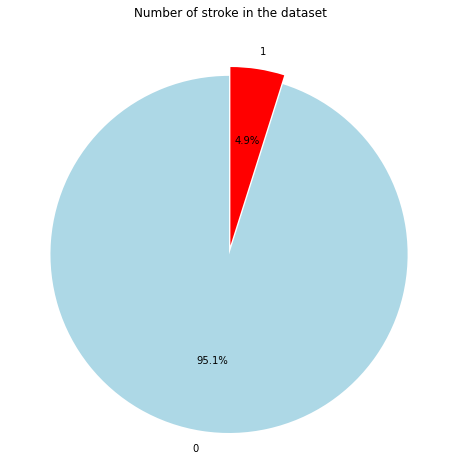

In [79]:
labels =df['stroke'].value_counts(sort = True).index
sizes = df['stroke'].value_counts(sort = True)

colors = ["lightblue","red"]
 
plt.figure(figsize=(8,10))
plt.pie(sizes, explode=(0.05,0), labels=labels, colors=colors, autopct='%1.1f%%', startangle=90,)

plt.title('Number of stroke in the dataset')
plt.show()

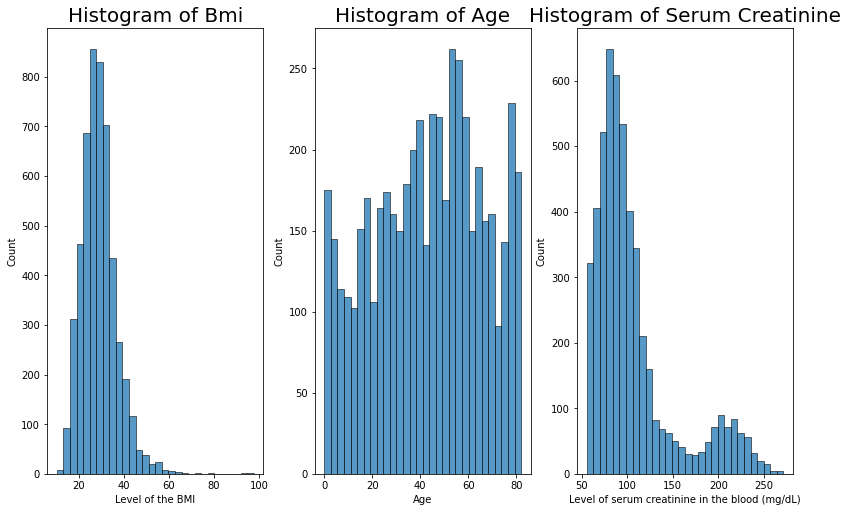

In [80]:
def plot_hist(col, bins=30, title="",xlabel="",ax=None):
    sns.histplot(col, bins=bins,ax=ax)
    ax.set_title(f'Histogram of {title}',fontsize=20)
    ax.set_xlabel(xlabel)

fig, axes = plt.subplots(1,3,figsize=(11,7),constrained_layout=True)
plot_hist(df.bmi,
          title='Bmi',
          xlabel="Level of the BMI",
          ax=axes[0])
plot_hist(df.age,
          bins=30,
          title='Age',
          xlabel='Age',
          ax=axes[1])
plot_hist(df.avg_glucose_level,
          title='Serum Creatinine', 
          xlabel='Level of serum creatinine in the blood (mg/dL)',
          ax=axes[2])

plt.show()

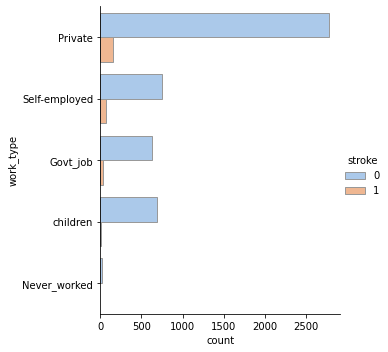

In [81]:
sns.catplot(y="work_type", 
            hue="stroke", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df)

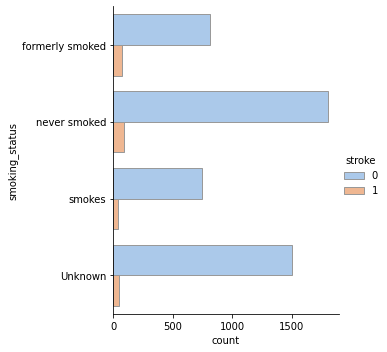

In [82]:
sns.catplot(y="smoking_status", 
            hue="stroke", 
            kind="count",
            palette="pastel", 
            edgecolor=".6",
            data=df)

<Figure size 1224x504 with 0 Axes>

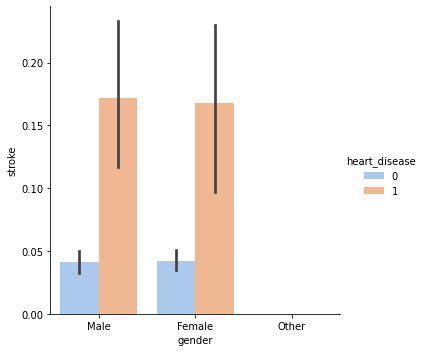

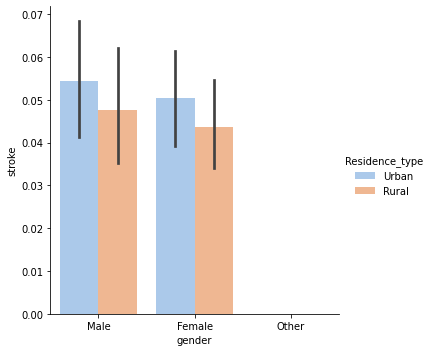

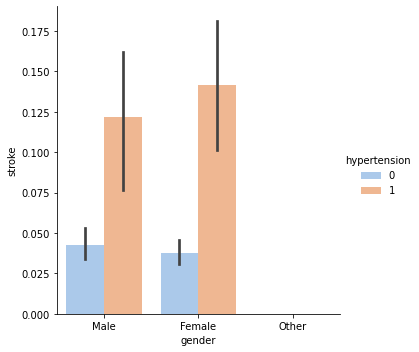

In [83]:
plt.figure(figsize=(17,7))
sns.catplot(x="gender", y="stroke", hue="heart_disease", palette="pastel", kind="bar", data=df)
sns.catplot(x="gender", y="stroke", hue="Residence_type", palette="pastel", kind="bar", data=df)
sns.catplot(x="gender", y="stroke", hue="hypertension", palette="pastel", kind="bar", data=df)
plt.show()

In [84]:
len_data = len(df)
len_w = len(df[df["gender"]=="Male"])
len_m = len_data - len_w

men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke

women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke

labels = ['Men with stroke','Men healthy','Women with stroke','Women healthy']
values = [men_stroke, men_no_stroke, women_stroke, women_no_stroke]

fig = go.Figure(data=[go.Pie(labels=labels, values=values,textinfo='label+percent',hole=0.4)])
fig.update_layout(
    title_text="Distribution of stroke EVENT according to their gender")
fig.show()

In [85]:
fig = px.parallel_categories(df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status', 'stroke']], color='stroke', color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

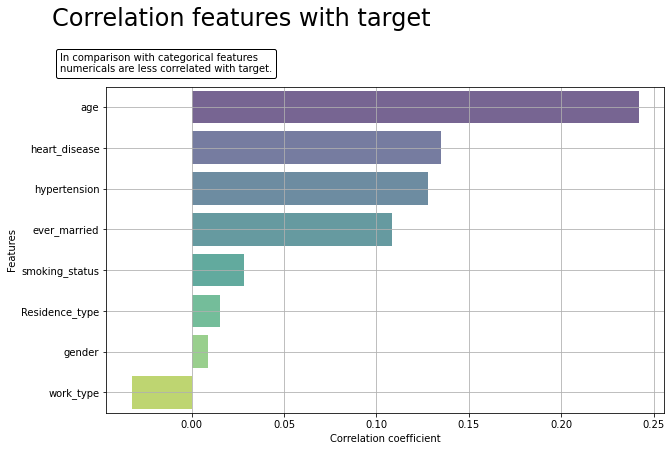

In [86]:
le = LabelEncoder()
en_df = df.apply(le.fit_transform)
en_df.head()

features=['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status']
from matplotlib.offsetbox import AnchoredText
correlation_table = []
for cols in features:
    y = en_df["stroke"]
    x = en_df[cols]
    corr = np.corrcoef(x, y)[1][0]
    dict ={
        'Features': cols,
        'Correlation coefficient' : corr,
        'Feat_type': 'numerical'
    }
    correlation_table.append(dict)
dF1 = pd.DataFrame(correlation_table)
fig = plt.figure(figsize=(10,6))
ax = sns.barplot(x="Correlation coefficient", y="Features", 
                     data=dF1.sort_values("Correlation coefficient", ascending=False),
                     palette='viridis', alpha=0.75)
ax.grid()

title =  'Correlation features with target'
sub_title = 'In comparison with categorical features \
\nnumericals are less correlated with target.'

plt.gcf().text(0.05, 1.02, title, fontsize=24)
#plt.gcf().text(0.05, 0.9, sub_title, fontsize=14)

at1 = AnchoredText(sub_title,
                   loc='lower left', frameon=True,
                   bbox_to_anchor=(-0.1, 1.01),
                   bbox_transform=ax.transAxes,
                   #prop=dict(size=8),
                   )
at1.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax.add_artist(at1)

<Figure size 576x864 with 0 Axes>

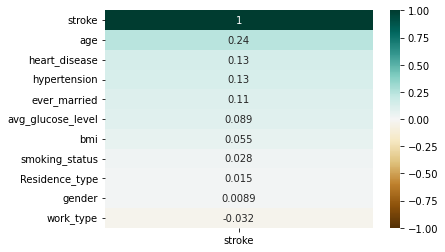

<Figure size 576x864 with 0 Axes>

In [87]:
fig, ax = plt.subplots()
corr = en_df.corr()[['stroke']].sort_values(by='stroke', ascending=False)
sns.heatmap(corr, vmin=-1, vmax=1, ax=ax, annot=True, cmap = 'BrBG')
plt.figure(figsize=(8, 12))

<AxesSubplot:>

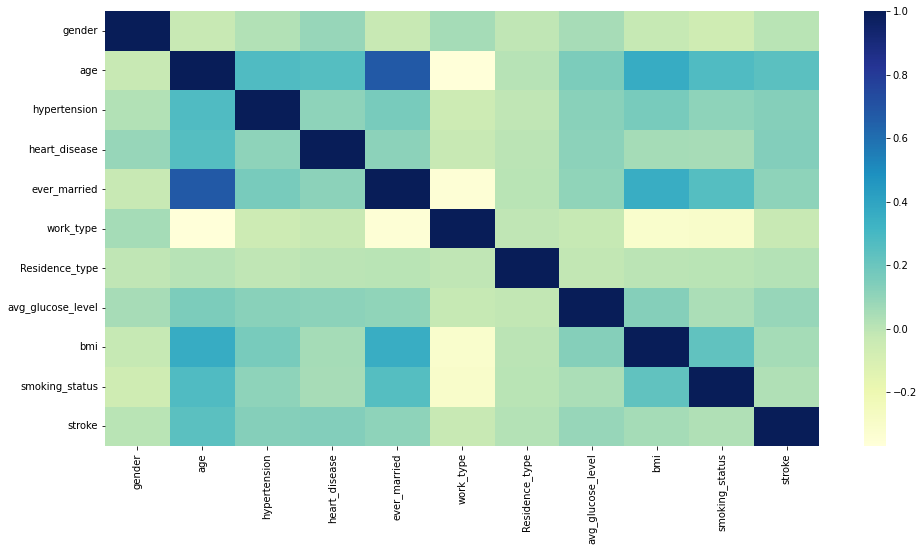

In [88]:
plt.figure(figsize=(16,8))
sns.heatmap(en_df.corr(),cmap='YlGnBu')

# Prediction

Prediction using KNN

In [89]:
# from sklearn.utils import shuffle
# df = shuffle(df, random_state=1)
# df

### Encode Categorical Variable

In [90]:
from sklearn.preprocessing import LabelEncoder
le_gender = LabelEncoder()
le_marriage = LabelEncoder()
le_work = LabelEncoder()
le_residence = LabelEncoder()
le_smoke = LabelEncoder()

In [91]:
df["gender"] =  le_gender.fit_transform(df["gender"])
df["ever_married"] = le_marriage.fit_transform(df["ever_married"])
df["work_type"] = le_work.fit_transform(df["work_type"])
df["Residence_type"] = le_residence.fit_transform(df["Residence_type"])
df["smoking_status"] = le_smoke.fit_transform(df["smoking_status"])

In [92]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [93]:
X

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,1,2,1,228.69,36.6,1
1,0,61.0,0,0,1,3,0,202.21,32.8,2
2,1,80.0,0,1,1,2,0,105.92,32.5,2
3,0,49.0,0,0,1,2,1,171.23,34.4,3
4,0,79.0,1,0,1,3,0,174.12,24.0,2
...,...,...,...,...,...,...,...,...,...,...
5105,0,80.0,1,0,1,2,1,83.75,32.6,2
5106,0,81.0,0,0,1,3,1,125.20,40.0,2
5107,0,35.0,0,0,1,3,0,82.99,30.6,2
5108,1,51.0,0,0,1,2,0,166.29,25.6,1


In [94]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

### Test and training data splitting

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

### Standard scaling

In [96]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### SMOTE( Synthetic Minority Over-Sampling Technique)

Used to handle imbalance data

ini dipake buat memperbanyak data yang jumlahnya sedikit, makanya row yang stroke (1) jadi 3899

In [97]:
print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

Before OverSampling, counts of label '1': 189
Before OverSampling, counts of label '0': 3899 



In [98]:
print('After OverSampling, the shape of X_train: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of y_train: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

After OverSampling, the shape of X_train: (7798, 10)
After OverSampling, the shape of y_train: (7798,) 

After OverSampling, counts of label '1': 3899
After OverSampling, counts of label '0': 3899


### KNN

In [99]:
from sklearn.neighbors import KNeighborsClassifier  
best_k = -1
best_test_score = -1

for i in range(1,11):    
    classifier= KNeighborsClassifier(n_neighbors=i, p=1, weights = "uniform")  
#     classifier.fit(X_train, y_train)
    classifier.fit(X_train_res, y_train_res.ravel())
    
    y_pred= classifier.predict(X_test)
    
    print("Neighbour = {k}".format(k = i))
#     print("The training accuracy: {score}".format(score = (classifier.score(X_train,y_train)*100).round(2)))
    print("The training accuracy: {score}".format(score = (classifier.score(X_train_res,y_train_res.ravel())*100).round(2)))
    print('The Test accuracy: {score}'.format(score = (classifier.score(X_test,y_test)*100).round(2)))
    
    if classifier.score(X_test,y_test) > best_test_score:
        best_test_score = classifier.score(X_test, y_test)
        best_k = i

print("\n\nBest k-neighbor= {k}".format(k = best_k))

Neighbour = 1
The training accuracy: 100.0
The Test accuracy: 88.65
Neighbour = 2
The training accuracy: 99.65
The Test accuracy: 89.53
Neighbour = 3
The training accuracy: 97.13
The Test accuracy: 84.93
Neighbour = 4
The training accuracy: 97.41
The Test accuracy: 85.91
Neighbour = 5
The training accuracy: 95.28
The Test accuracy: 83.17
Neighbour = 6
The training accuracy: 95.47
The Test accuracy: 84.44
Neighbour = 7
The training accuracy: 93.63
The Test accuracy: 81.51
Neighbour = 8
The training accuracy: 93.92
The Test accuracy: 82.19
Neighbour = 9
The training accuracy: 92.28
The Test accuracy: 79.94
Neighbour = 10
The training accuracy: 92.59
The Test accuracy: 81.12


Best k-neighbor= 2


In [100]:
classifier= KNeighborsClassifier(n_neighbors=best_k, p=2)  
classifier.fit(X_train_res, y_train_res.ravel())
y_pred= classifier.predict(X_test)

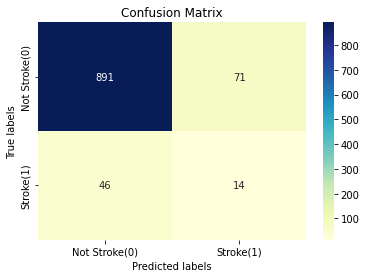

In [101]:
cnf_matrix = confusion_matrix(y_test, y_pred)

ax= plt.subplot()

# Confusion matrix menggunakan seaborn

sns.heatmap(cnf_matrix, annot=True, fmt='g', ax=ax, cmap="YlGnBu");  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Not Stroke(0)', 'Stroke(1)']); 
ax.yaxis.set_ticklabels(['Not Stroke(0)', 'Stroke(1)']);

In [102]:
print(classification_report(y_test, y_pred))
print('Accuracy Score: ',accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       962
           1       0.16      0.23      0.19        60

    accuracy                           0.89      1022
   macro avg       0.56      0.58      0.57      1022
weighted avg       0.90      0.89      0.89      1022

Accuracy Score:  0.8855185909980431


In [103]:
report = classification_report(y_test, y_pred)
report

'              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94       962\n           1       0.16      0.23      0.19        60\n\n    accuracy                           0.89      1022\n   macro avg       0.56      0.58      0.57      1022\nweighted avg       0.90      0.89      0.89      1022\n'

In [104]:
X_test

array([[-0.84756655, -0.0488836 , -0.3275041 , ...,  0.16130009,
         1.06942914, -0.34236535],
       [-0.84756655,  1.54304189, -0.3275041 , ..., -0.60449313,
         0.14735498, -0.34236535],
       [ 1.17984835, -0.66796574, -0.3275041 , ..., -0.71531129,
        -0.46303214,  1.52126922],
       ...,
       [ 1.17984835, -1.50814864, -0.3275041 , ..., -0.17292042,
        -0.73575831, -1.27418264],
       [-0.84756655,  0.12799701, -0.3275041 , ..., -0.24378223,
        -0.52796694,  0.58945193],
       [-0.84756655, -0.00466345,  3.05339685, ..., -1.07580144,
         2.12137291, -1.27418264]])

In [105]:
# coba= sc.inverse_transform(X_train)
# coba[0]

In [106]:
from mlxtend.plotting import plot_decision_regions
from sklearn.decomposition import PCA

def knn_comparison(data, k):
    pca = PCA(n_components = 2)
    
    x = data.iloc[:,:-1].values
    x = pca.fit_transform(x)
    y = data['stroke'].astype(int).values
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(x, y)# Plotting decision region
    plot_decision_regions(x, y, clf=clf)# Adding axes annotations
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Knn with K='+ str(k))
    plt.show()

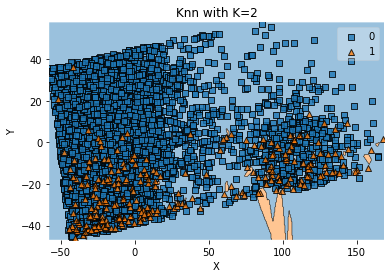

In [107]:
knn_comparison(df, best_k)

In [109]:
from matplotlib.colors import ListedColormap
pca = PCA(n_components = 2)

X_train = sc.inverse_transform(X_train)
X_train = pca.fit_transform(X_train)

X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 1),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 1))
plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], color = ListedColormap(('red', 'green'))(i), label = j)
plt.title('K-NN (Training set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()


ValueError: operands could not be broadcast together with shapes (4088,2) (10,) (4088,2) 

In [ ]:
X_set, y_set = sc.inverse_transform(X_test), y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 10, stop = X_set[:, 0].max() + 10, step = 1),
                     np.arange(start = X_set[:, 1].min() - 1000, stop = X_set[:, 1].max() + 1000, step = 1))
plt.contourf(X1, X2, classifier.predict(sc.transform(np.array([X1.ravel(), X2.ravel()]).T)).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1], color = ListedColormap(('red', 'green'))(i), label = j)
plt.title('K-NN (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()

In [ ]:
lalala

# Preparing to export models for web app

In [ ]:
# gender 	age 	hypertension 	heart_disease 	ever_married 	work_type 	Residence_type 	avg_glucose_level 	bmi 	smoking_status 	stroke
# Male 	67.0 	0 	1 	Yes 	Private 	Urban 	228.69 	36.6 	formerly smoked 	1

# array = np.array([["Male", 67.0, 1, 1, "Yes", "Private", "Urban", 228.69, 36.6, "smokes"]])

array = np.array([["Male", 80, 1, 1, "Yes", "Private", "Urban", 228.69, 40, "smokes"]])

array[:, 0] =  le_gender.transform(array[:, 0])
array[:, 4] = le_marriage.transform(array[:, 4])
array[:, 5] = le_work.transform(array[:, 5])
array[:, 6] = le_residence.transform(array[:,6])
array[:, 9] = le_smoke.transform(array[:,9])

index_values = [0]
column_values = ["gender", "age", "hypertension", "heart_disease","ever_married", "work_type", "Residence_type","avg_glucose_level", "bmi", "smoking_status"]
X = pd.DataFrame(data = array, 
                 index = index_values,
                columns = column_values)
# X = pd.DataFrame(data = array, 
#                  index = index_values,
#                 )

X = sc.transform(X)
X

In [ ]:
y_pred = classifier.predict(X)
y_pred

In [ ]:
import pickle
import joblib

In [ ]:
data = {"model": classifier, 
        "le_gender": le_gender, 
        "le_marriage": le_marriage, 
        "le_work": le_work, 
        "le_residence": le_residence,
        "le_smoke": le_smoke
       }

with open("model_knn.pkl", "wb") as file:
    pickle.dump(data,file)

joblib.dump(sc, "scaler.pkl") 

In [ ]:
with open("model_knn.pkl", "rb") as file:
    data = pickle.load(file)
    
sc = joblib.load("scaler.pkl")

classifier_loaded = data["model"]
le_gender = data["le_gender"]
le_marriage = data["le_marriage"]
le_work = data["le_work"]
le_residence = data["le_residence"]
le_smoke = data["le_smoke"]

array = np.array([["Male", 50, 1, 1, "Yes", "Private", "Urban", 228.69, 30, "smokes"]])

array[:, 0] =  le_gender.transform(array[:, 0])
array[:, 4] = le_marriage.transform(array[:, 4])
array[:, 5] = le_work.transform(array[:, 5])
array[:, 6] = le_residence.transform(array[:,6])
array[:, 9] = le_smoke.transform(array[:,9])

index_values = [0]
column_values = ["gender", "age", "hypertension", "heart_disease","ever_married", "work_type", "Residence_type","avg_glucose_level", "bmi", "smoking_status"]

X = pd.DataFrame(data = array, 
                 index = index_values,
                columns = column_values)
# X = pd.DataFrame(data = array, 
#                  index = index_values,
#                 )
X = sc.transform(X)
X

In [ ]:
y_pred = classifier_loaded.predict(X)
y_pred